In [1]:
# Jupyter notebook in Jupytext format

## Initialisation

In [2]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\ode-biomarker-project


In [3]:
from PathLoader import PathLoader #noqa: E402

path_loader = PathLoader("data_config.env", "current_user.env")

In [4]:
from DataLink import DataLink #noqa: E402

data_link = DataLink(path_loader, "data_codes.csv")

In [5]:
folder_name = "ThesisResult4-FeatureSelectionBenchmark"
exp_id = "v5_mrmr_vs_gffs_anova_prefilter"

if not os.path.exists(f"{path_loader.get_data_path()}data/results/{folder_name}/{exp_id}"):
    os.makedirs(f"{path_loader.get_data_path()}data/results/{folder_name}/{exp_id}")

file_save_path = f"{path_loader.get_data_path()}data/results/{folder_name}/{exp_id}/"

In [6]:
# Load Proteomics Palbociclib dataset
loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(
    loading_code
)

print(f"Proteomic feature data shape: {proteomic_feature_data.shape}")
print(f"Proteomic label data shape: {proteomic_label_data.shape}")

Proteomic feature data shape: (737, 6692)
Proteomic label data shape: (737,)


In [7]:
# Data preparation and alignment
import numpy as np #noqa: E402

# Ensure numeric only
proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])

# Align indices
common_indices = sorted(
    set(proteomic_feature_data.index) & set(proteomic_label_data.index)
)
feature_data = proteomic_feature_data.loc[common_indices]
label_data = proteomic_label_data.loc[common_indices]

print(f"Final aligned dataset shape: {feature_data.shape}")
print(f"Final aligned label shape: {label_data.shape}")

Final aligned dataset shape: (737, 6692)
Final aligned label shape: (737,)


## Functions

In [8]:
from typing import Dict, List, Literal #noqa: E402
import numpy as np #noqa: E402
import pandas as pd #noqa: E402
from scipy.stats import pearsonr, spearmanr #noqa: E402
from sklearn.metrics import r2_score #noqa: E402
from sklearn.dummy import DummyRegressor #noqa: E402
from sklearn.preprocessing import StandardScaler #noqa: E402
from toolkit import FirstQuantileImputer, f_regression_select, get_model_from_string #noqa: E402
from toolkit import (
    mrmr_select_fcq, 
    mrmr_select_fcq_fast,
    mutual_information_select,
    select_random_features,
) #noqa: E402
import time #noqa: E402

In [9]:
def random_select_wrapper(X: pd.DataFrame, y: pd.Series, k: int) -> tuple:
    """Wrapper function for random feature selection that returns dummy scores"""
    selected_features, _ = select_random_features(X, y, k)
    # Return dummy scores (all zeros) since random selection has no meaningful scores
    dummy_scores = np.zeros(len(selected_features))
    return selected_features, dummy_scores

In [10]:
def _drop_correlated_columns(X: pd.DataFrame, threshold: float = 0.95) -> List[str]:
    """Drop highly correlated columns to reduce redundancy"""
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()
    for col in sorted(upper.columns):
        if col in to_drop:
            continue
        high_corr = upper.index[upper[col] > threshold].tolist()
        to_drop.update(high_corr)
    return [c for c in X.columns if c not in to_drop]

In [11]:
def create_feature_selection_pipeline(
    selection_method: callable, k: int, method_name: str, model_name: str
):
    """Create pipeline for feature selection methods"""

    def pipeline_function(X_train: pd.DataFrame, y_train: pd.Series, rng: int):
        # 1) Sanitize inputs and imputation
        X_train = X_train.replace([np.inf, -np.inf], np.nan)
        y_train = pd.Series(y_train).replace([np.inf, -np.inf], np.nan)
        mask = ~y_train.isna()
        X_train, y_train = X_train.loc[mask], y_train.loc[mask]

        # 2) Imputation
        imputer = FirstQuantileImputer().fit(X_train)
        Xtr = imputer.transform(X_train, return_df=True).astype(float)
        Xtr = Xtr.fillna(0.0)

        # 3) Correlation filtering (applied to both train and test)
        # Use the working function from your baseline code [1]
        corr_keep_cols = _drop_correlated_columns(Xtr, threshold=0.95)
        Xtr_filtered = Xtr[corr_keep_cols]

        # 4) Feature selection
        k_sel = min(k, Xtr_filtered.shape[1]) if Xtr_filtered.shape[1] > 0 else 0
        if k_sel == 0:
            selected_features, selector_scores = [], np.array([])
            no_features = True
        else:
            selected_features, selector_scores = selection_method(
                Xtr_filtered, y_train, k_sel
            )
            no_features = False

        # 5) Standardization and model training
        if no_features or len(selected_features) == 0:
            model = DummyRegressor(strategy="mean")
            model_type = "DummyRegressor(mean)"
            model_params = {"strategy": "mean"}
            sel_train = Xtr_filtered.iloc[:, :0]
        else:
            sel_train = Xtr_filtered[selected_features]
            scaler = StandardScaler()
            sel_train_scaled = scaler.fit_transform(sel_train)
            sel_train_scaled = pd.DataFrame(
                sel_train_scaled, index=sel_train.index, columns=selected_features
            )

            # Train model
            if model_name == "LinearRegression":
                model = get_model_from_string("LinearRegression")
            elif model_name == "KNeighborsRegressor":
                model = get_model_from_string(
                    "KNeighborsRegressor", n_neighbors=5, weights="distance", p=2
                )
            elif model_name == "SVR":
                model = get_model_from_string("SVR", kernel="linear", C=1.0)
            else:
                raise ValueError(f"Unsupported model: {model_name}")

            model.fit(sel_train_scaled, y_train)
            model_type = model_name
            model_params = (
                model.get_params(deep=False) if hasattr(model, "get_params") else {}
            )

        return {
            "imputer": imputer,
            "corr_keep_cols": corr_keep_cols,
            "selected_features": list(selected_features),
            "selector_scores": np.array(selector_scores),
            "model": model,
            "model_type": model_type,
            "model_params": model_params,
            "scaler": scaler if not no_features else None,
            "no_features": no_features,
            "rng": rng,
        }

    return pipeline_function

In [12]:
def feature_selection_eval(
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    pipeline_components: Dict,
    metric_primary: Literal["r2", "pearson_r", "spearman_r"] = "r2",
) -> Dict:
    """Evaluation function for feature selection benchmarking"""

    # Unpack components following the structure from working baseline code [1]
    imputer = pipeline_components["imputer"]
    corr_keep = set(pipeline_components["corr_keep_cols"])
    selected = list(pipeline_components["selected_features"])
    selector_scores = pipeline_components["selector_scores"]
    model = pipeline_components["model"]
    model_name = pipeline_components["model_type"]
    scaler = pipeline_components.get("scaler", None)
    no_features = pipeline_components.get("no_features", False)

    # Apply identical transforms as training
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    y_test = pd.Series(y_test).replace([np.inf, -np.inf], np.nan)
    mask_y = ~y_test.isna()
    X_test, y_test = X_test.loc[mask_y], y_test.loc[mask_y]

    Xti = imputer.transform(X_test, return_df=True).astype(float).fillna(0.0)

    # Apply same correlation filtering as training [1]
    cols_after_corr = [c for c in Xti.columns if c in corr_keep]
    Xti = Xti[cols_after_corr]

    # Select features
    Xsel = Xti[selected] if len(selected) > 0 else Xti.iloc[:, :0]

    # Standardize if scaler exists (i.e., features were selected)
    if scaler is not None and len(selected) > 0:
        Xsel_scaled = scaler.transform(Xsel)
        Xsel_scaled = pd.DataFrame(Xsel_scaled, index=Xsel.index, columns=selected)
    else:
        Xsel_scaled = Xsel

    # Predict
    if no_features or Xsel.shape[1] == 0:
        y_pred = np.full_like(
            y_test.values, fill_value=float(y_test.mean()), dtype=float
        )
    else:
        y_pred = np.asarray(model.predict(Xsel_scaled), dtype=float)

    # Calculate metrics (following the exact structure from baseline_eval [1])
    mask_fin = np.isfinite(y_test.values) & np.isfinite(y_pred)
    y_t = y_test.values[mask_fin]
    y_p = y_pred[mask_fin]

    if len(y_t) < 2:
        r2 = np.nan
        pearson_r = pearson_p = np.nan
        spearman_rho = spearman_p = np.nan
    else:
        r2 = r2_score(y_t, y_p)
        pearson_r, pearson_p = pearsonr(y_t, y_p)
        spearman_rho, spearman_p = spearmanr(y_t, y_p)

    metrics = {
        "r2": float(r2) if np.isfinite(r2) else np.nan,
        "pearson_r": float(pearson_r) if np.isfinite(pearson_r) else np.nan,
        "pearson_p": float(pearson_p) if np.isfinite(pearson_p) else np.nan,
        "spearman_rho": float(spearman_rho) if np.isfinite(spearman_rho) else np.nan,
        "spearman_p": float(spearman_p) if np.isfinite(spearman_p) else np.nan,
        "n_test_samples_used": len(y_t),
    }

    # Feature importance
    if not no_features and hasattr(model, "feature_importances_") and len(selected) > 0:
        fi = (np.array(selected), model.feature_importances_)
    elif not no_features and model_name in ("LinearRegression",) and len(selected) > 0:
        coef = getattr(model, "coef_", np.zeros(len(selected)))
        fi = (np.array(selected), np.abs(coef))
    else:
        fi = (np.array(selected), np.zeros(len(selected)))

    primary = metrics.get(metric_primary, metrics["r2"])

    return {
        "feature_importance": fi,
        "feature_importance_from": "model",
        "model_performance": float(primary) if primary is not None else np.nan,
        "metrics": metrics,
        "selected_features": selected,
        "model_name": model_name,
        "selected_scores": selector_scores,
        "k": len(selected),
        "rng": pipeline_components.get("rng", None),
        "y_pred": y_p,
        "y_true_index": y_test.index[mask_fin],
    }

## Computational Cost Analysis Functions

In [13]:
import matplotlib.pyplot as plt #noqa: E402
import seaborn as sns #noqa: E402
from scipy.optimize import curve_fit #noqa: E402
from scipy.stats import linregress, ttest_ind #noqa: E402
import warnings #noqa: E402
warnings.filterwarnings('ignore')

In [14]:
def analyze_time_complexity(df_benchmark, report_file=None):
    """Analyze time complexity of feature selection methods"""
    
    save_and_print("## Computational Cost Analysis: Time Complexity", report_file, level="section")
    
    # Group by method and k_value for time analysis
    time_by_method_k = df_benchmark.groupby(['method', 'k_value'])['feature_selection_time'].agg([
        'mean', 'std', 'count', 'min', 'max'
    ]).reset_index()
    
    save_and_print("### Time Statistics by Method and k-value", report_file, level="subsection")
    save_and_print(time_by_method_k.round(4).to_string(), report_file, level="info")
    
    # Complexity model functions
    def linear_func(x, a, b):
        return a * x + b
    
    def quadratic_func(x, a, b, c):
        return a * x**2 + b * x + c
    
    def exponential_func(x, a, b):
        return a * np.exp(b * x)
    
    # Analyze complexity for each method
    complexity_results = {}
    methods = df_benchmark['method'].unique()
    
    for method in methods:
        method_data = df_benchmark[df_benchmark['method'] == method]
        k_values = sorted(method_data['k_value'].unique())
        
        # Calculate mean time for each k
        mean_times = []
        for k in k_values:
            k_data = method_data[method_data['k_value'] == k]
            mean_times.append(k_data['feature_selection_time'].mean())
        
        # Fit different complexity models
        x_data = np.array(k_values)
        y_data = np.array(mean_times)
        
        complexity_results[method] = {
            'k_values': k_values,
            'mean_times': mean_times,
            'fits': {}
        }
        
        # Linear fit
        try:
            popt_lin, _ = curve_fit(linear_func, x_data, y_data, maxfev=5000)
            y_pred_lin = linear_func(x_data, *popt_lin)
            r2_lin = 1 - np.sum((y_data - y_pred_lin)**2) / np.sum((y_data - np.mean(y_data))**2)
            complexity_results[method]['fits']['linear'] = {
                'params': popt_lin, 'r2': r2_lin
            }
        except:
            complexity_results[method]['fits']['linear'] = {'r2': np.nan}
        
        # Quadratic fit
        try:
            popt_quad, _ = curve_fit(quadratic_func, x_data, y_data, maxfev=5000)
            y_pred_quad = quadratic_func(x_data, *popt_quad)
            r2_quad = 1 - np.sum((y_data - y_pred_quad)**2) / np.sum((y_data - np.mean(y_data))**2)
            complexity_results[method]['fits']['quadratic'] = {
                'params': popt_quad, 'r2': r2_quad
            }
        except:
            complexity_results[method]['fits']['quadratic'] = {'r2': np.nan}
        
        # Exponential fit
        try:
            popt_exp, _ = curve_fit(exponential_func, x_data, y_data, maxfev=5000, p0=[1, 0.1])
            y_pred_exp = exponential_func(x_data, *popt_exp)
            r2_exp = 1 - np.sum((y_data - y_pred_exp)**2) / np.sum((y_data - np.mean(y_data))**2)
            complexity_results[method]['fits']['exponential'] = {
                'params': popt_exp, 'r2': r2_exp
            }
        except:
            complexity_results[method]['fits']['exponential'] = {'r2': np.nan}
    
    # Print complexity analysis results
    save_and_print("### Time Complexity Model Fits", report_file, level="subsection")
    for method, results in complexity_results.items():
        save_and_print(f"**{method.upper()} Method:**", report_file, level="info")
        for model_name, fit_info in results['fits'].items():
            if not np.isnan(fit_info['r2']):
                save_and_print(f"  {model_name.capitalize()} fit R²: {fit_info['r2']:.4f}", report_file, level="info")
    
    return complexity_results, time_by_method_k

In [15]:
def plot_time_complexity(df_benchmark, complexity_results, file_save_path, exp_id):
    """Create time complexity visualization plots"""
    
    # Set up plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    axes = axes.flatten()
    
    # Plot 1: Time vs k-value for both methods
    plt.sca(axes[0])
    for method in df_benchmark['method'].unique():
        method_data = df_benchmark[df_benchmark['method'] == method]
        k_values = sorted(method_data['k_value'].unique())
        mean_times = [method_data[method_data['k_value'] == k]['feature_selection_time'].mean() for k in k_values]
        std_times = [method_data[method_data['k_value'] == k]['feature_selection_time'].std() for k in k_values]
        
        plt.errorbar(k_values, mean_times, yerr=std_times, 
                    label=method.upper(), marker='o', capsize=5, linewidth=2)
    
    plt.xlabel('Number of Features Selected (k)')
    plt.ylabel('Time (seconds)')
    plt.title('Feature Selection Time vs k-value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization
    
    # Plot 2: Speedup ratio comparison between methods
    plt.sca(axes[1])
    # Use the first two methods for comparison (or all methods if more than 2)
    if len(df_benchmark['method'].unique()) >= 2:
        method1 = df_benchmark['method'].unique()[0]
        method2 = df_benchmark['method'].unique()[1]
        
        method1_data = df_benchmark[df_benchmark['method'] == method1]
        method2_data = df_benchmark[df_benchmark['method'] == method2]
        
        k_values = sorted(method1_data['k_value'].unique())
        speedup_ratios = []
        
        for k in k_values:
            method1_time = method1_data[method1_data['k_value'] == k]['feature_selection_time'].mean()
            method2_time = method2_data[method2_data['k_value'] == k]['feature_selection_time'].mean()
            if method2_time > 0:  # Avoid division by zero
                speedup_ratios.append(method1_time / method2_time)
            else:
                speedup_ratios.append(np.nan)
        
        plt.plot(k_values, speedup_ratios, 'ro-', linewidth=2, markersize=8)
        plt.xlabel('Number of Features Selected (k)')
        plt.ylabel(f'Speedup Ratio ({method1.upper()} Time / {method2.upper()} Time)')
        plt.title(f'Computational Speedup: {method2.upper()} vs {method1.upper()}')
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
    else:
        plt.text(0.5, 0.5, 'Need at least 2 methods for speedup comparison', 
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
        plt.title('Speedup Comparison (Insufficient Methods)')
    
    # Plot 3: Time distribution by method
    plt.sca(axes[2])
    sns.boxplot(data=df_benchmark, x='method', y='feature_selection_time', ax=axes[2])
    plt.xlabel('Feature Selection Method')
    plt.ylabel('Time (seconds)')
    plt.title('Distribution of Execution Times by Method')
    plt.yscale('log')
    
    # Plot 4: Time per feature selected
    plt.sca(axes[3])
    for method in df_benchmark['method'].unique():
        method_data = df_benchmark[df_benchmark['method'] == method]
        k_values = sorted(method_data['k_value'].unique())
        time_per_feature = []
        
        for k in k_values:
            k_data = method_data[method_data['k_value'] == k]
            mean_time = k_data['feature_selection_time'].mean()
            time_per_feature.append(mean_time / k)
        
        plt.plot(k_values, time_per_feature, marker='s', label=method.upper(), linewidth=2)
    
    plt.xlabel('Number of Features Selected (k)')
    plt.ylabel('Time per Feature (seconds)')
    plt.title('Time Efficiency per Feature Selected')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f"{file_save_path}computational_cost_analysis_{exp_id}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

In [16]:
def statistical_comparison(df_benchmark, report_file=None):
    """Perform statistical comparison of computational costs"""
    
    save_and_print("## Statistical Comparison of Computational Costs", report_file, level="section")
    
    # Basic statistics
    save_and_print("### Basic Time Statistics", report_file, level="subsection")
    stats_summary = df_benchmark.groupby('method')['feature_selection_time'].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).round(4)
    save_and_print(stats_summary.to_string(), report_file, level="info")
    
    # Correlation analysis
    correlation = df_benchmark['feature_selection_time'].corr(df_benchmark['k_value'])
    save_and_print(f"### Correlation Analysis", report_file, level="subsection")
    save_and_print(f"Correlation between time and k-value: {correlation:.4f}", report_file, level="info")
    
    # Perform pairwise statistical comparisons for all methods
    methods = df_benchmark['method'].unique()
    if len(methods) >= 2:
        save_and_print("### Pairwise Statistical Significance Tests", report_file, level="subsection")
        for i, method1 in enumerate(methods):
            for j, method2 in enumerate(methods):
                if i < j:
                    method1_times = df_benchmark[df_benchmark['method'] == method1]['feature_selection_time']
                    method2_times = df_benchmark[df_benchmark['method'] == method2]['feature_selection_time']
                    
                    if len(method1_times) > 0 and len(method2_times) > 0:
                        t_stat, p_value = ttest_ind(method1_times, method2_times, equal_var=False)
                        speedup_ratio = method1_times.mean() / method2_times.mean() if method2_times.mean() > 0 else np.inf
                        
                        save_and_print(f"{method1.upper()} vs {method2.upper()}:", report_file, level="info")
                        save_and_print(f"  T-statistic: {t_stat:.4f}", report_file, level="info")
                        save_and_print(f"  P-value: {p_value:.4e}", report_file, level="info")
                        save_and_print(f"  Significant difference: {'YES' if p_value < 0.05 else 'NO'}", report_file, level="info")
                        save_and_print(f"  Speedup ratio ({method1.upper()}/{method2.upper()}): {speedup_ratio:.1f}x", report_file, level="info")
    
    return {
        'correlation': correlation
    }

In [17]:
def generate_practical_recommendations(df_benchmark, complexity_results, stats_results, report_file=None):
    """Generate practical recommendations based on computational cost analysis"""
    
    save_and_print("## Practical Recommendations", report_file, level="section")
    
    # Calculate time estimates for different scenarios using actual k-values from data
    k_values = sorted(df_benchmark['k_value'].unique())
    
    save_and_print("### Time Estimates by k-value", report_file, level="subsection")
    for k in k_values:
        time_estimates = {}
        for method in df_benchmark['method'].unique():
            method_estimate = df_benchmark[(df_benchmark['method'] == method) & 
                                         (df_benchmark['k_value'] == k)]['feature_selection_time'].mean()
            time_estimates[method] = method_estimate
        
        save_and_print(f"k={k}:", report_file, level="info")
        for method, estimate in time_estimates.items():
            save_and_print(f"  {method.upper()} estimate: {estimate:.4f} seconds", report_file, level="info")
        
        # Calculate speedup if there are at least 2 methods
        if len(time_estimates) >= 2:
            methods = list(time_estimates.keys())
            method1_time = time_estimates[methods[0]]
            method2_time = time_estimates[methods[1]]
            if method2_time > 0:
                speedup = method1_time / method2_time
                save_and_print(f"  Speedup ({methods[0].upper()}/{methods[1].upper()}): {speedup:.1f}x", report_file, level="info")
    
    # Recommendations based on complexity
    save_and_print("### Method Selection Guidelines", report_file, level="subsection")
    
    # Calculate average times for each method
    method_times = {}
    for method in df_benchmark['method'].unique():
        method_times[method] = df_benchmark[df_benchmark['method'] == method]['feature_selection_time'].mean()
    
    # Sort methods by speed (fastest first)
    sorted_methods = sorted(method_times.keys(), key=lambda x: method_times[x])
    
    if len(sorted_methods) >= 2:
        fastest_method = sorted_methods[0]
        slowest_method = sorted_methods[-1]
        speedup_ratio = method_times[slowest_method] / method_times[fastest_method] if method_times[fastest_method] > 0 else np.inf
        
        save_and_print(f"1. **For time-sensitive applications**: Use {fastest_method.upper()} method", report_file, level="info")
        save_and_print(f"   - {fastest_method.upper()} is ~{speedup_ratio:.0f}x faster than {slowest_method.upper()} on average", report_file, level="info")
        save_and_print("   - Suitable for real-time or interactive applications", report_file, level="info")
        
        save_and_print(f"2. **For performance-critical applications**: Consider {slowest_method.upper()}", report_file, level="info")
        save_and_print("   - May provide better feature selection quality", report_file, level="info")
        save_and_print("   - Use when computational time is not a constraint", report_file, level="info")
        
        save_and_print("3. **For large-scale analyses**:", report_file, level="info")
        save_and_print(f"   - Start with {fastest_method.upper()} for initial screening", report_file, level="info")
        save_and_print(f"   - Use {slowest_method.upper()} on promising subsets for refinement", report_file, level="info")
    
    save_and_print("4. **k-value selection**:", report_file, level="info")
    save_and_print("   - Time typically scales with k-value", report_file, level="info")
    save_and_print("   - Consider computational constraints when selecting k", report_file, level="info")
    
    return {
        'time_estimates': {k: {
            method: df_benchmark[(df_benchmark['method'] == method) & (df_benchmark['k_value'] == k)]['feature_selection_time'].mean()
            for method in df_benchmark['method'].unique()
        } for k in k_values}
    }

## Results and Visualisation

### Load data

In [18]:
def save_and_print(message, report_file=None, level="info"):
    """
    Print message to console and save to report file with proper formatting.
    
    Args:
        message: The message to print and save
        report_file: File object to save to (optional)
        level: Formatting level - "header", "section", "subsection", or "info"
    """
    # Print to console
    print(message)
    
    # Save to report with proper formatting
    if report_file:
        if level == "header":
            report_file.write(f"# {message}\n\n")
        elif level == "section":
            report_file.write(f"## {message}\n\n")
        elif level == "subsection":
            report_file.write(f"### {message}\n\n")
        else:  # info level
            report_file.write(f"{message}\n\n")
    
    return message

In [19]:
# Load saved feature selection benchmark (feature_selection_benchmark_v1.pkl)
import os
import pandas as pd
import time #noqa: E402

# Create a new report file for capturing print statements
print_report_path = f"{file_save_path}compute_cost_print_report_{exp_id}.md"
print_report_file = open(print_report_path, 'w', encoding='utf-8')

# Write header to the print report
print_report_file.write(f"# Computational Cost Analysis Report - {exp_id}\n\n")
print_report_file.write(f"**Generated**: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
print_report_file.write("This report analyzes the computational cost differences between feature selection methods.\n\n")

pkl_path = f"{path_loader.get_data_path()}data/results/{folder_name}/feature_selection_benchmark_{exp_id}.pkl"
if not os.path.exists(pkl_path):
    raise FileNotFoundError(f"Pickle not found: {pkl_path}")

df_benchmark = pd.read_pickle(pkl_path)
save_and_print(f"Loaded df_benchmark with shape: {df_benchmark.shape}", print_report_file, level="section")

Loaded df_benchmark with shape: (240, 15)


'Loaded df_benchmark with shape: (240, 15)'

### Fix Data Structure Issues

In [20]:
def parse_condition_column(df_benchmark):
    """Parse the condition column to extract method, k_value, and model_name correctly"""
    
    save_and_print("## Fixing Data Structure Issues", print_report_file, level="section")
    save_and_print("Parsing condition column to extract correct method, k_value, and model_name", print_report_file, level="info")
    
    # Create new columns based on condition parsing
    parsed_data = []
    
    for idx, row in df_benchmark.iterrows():
        condition = row['condition']
        
        # Parse the condition format: {method}_k{value}_{model}
        # Example: "mrmr_anova_prefilter_k5_KNeighborsRegressor"
        parts = condition.split('_')
        
        # Extract method (everything before the k-value part)
        method_parts = []
        k_value = None
        model_name = None
        
        for part in parts:
            if part.startswith('k'):
                # Found k-value part, extract numeric value
                k_value = int(part[1:])  # Remove 'k' prefix and convert to int
                # Everything before this is the method
                method = '_'.join(method_parts)
                # Everything after this is the model
                model_parts = parts[parts.index(part) + 1:]
                model_name = '_'.join(model_parts)
                break
            else:
                method_parts.append(part)
        
        # If we didn't find a k-value (shouldn't happen with valid data)
        if k_value is None:
            save_and_print(f"Warning: Could not parse k-value from condition: {condition}", print_report_file, level="info")
            method = '_'.join(method_parts[:-1]) if len(method_parts) > 1 else method_parts[0]
            model_name = parts[-1] if parts else 'unknown'
            k_value = 0
        
        parsed_data.append({
            'condition': condition,
            'parsed_method': method,
            'parsed_k_value': k_value,
            'parsed_model_name': model_name
        })
    
    # Create a DataFrame with parsed values
    parsed_df = pd.DataFrame(parsed_data)
    
    # Compare with existing columns
    save_and_print("### Comparison of Original vs Parsed Values", print_report_file, level="subsection")
    
    # Check method consistency
    method_mismatch = df_benchmark['method'] != parsed_df['parsed_method']
    if method_mismatch.any():
        save_and_print(f"Method mismatches found: {method_mismatch.sum()}/{len(df_benchmark)}", print_report_file, level="info")
        for idx in df_benchmark[method_mismatch].index[:5]:  # Show first 5 mismatches
            save_and_print(f"  Row {idx}: Original='{df_benchmark.loc[idx, 'method']}', Parsed='{parsed_df.loc[idx, 'parsed_method']}'", 
                          print_report_file, level="info")
    
    # Check k_value consistency
    k_mismatch = df_benchmark['k_value'] != parsed_df['parsed_k_value']
    if k_mismatch.any():
        save_and_print(f"K-value mismatches found: {k_mismatch.sum()}/{len(df_benchmark)}", print_report_file, level="info")
        for idx in df_benchmark[k_mismatch].index[:5]:
            save_and_print(f"  Row {idx}: Original={df_benchmark.loc[idx, 'k_value']}, Parsed={parsed_df.loc[idx, 'parsed_k_value']}", 
                          print_report_file, level="info")
    
    # Check model_name consistency
    model_mismatch = df_benchmark['model_name'] != parsed_df['parsed_model_name']
    if model_mismatch.any():
        save_and_print(f"Model name mismatches found: {model_mismatch.sum()}/{len(df_benchmark)}", print_report_file, level="info")
        for idx in df_benchmark[model_mismatch].index[:5]:
            save_and_print(f"  Row {idx}: Original='{df_benchmark.loc[idx, 'model_name']}', Parsed='{parsed_df.loc[idx, 'parsed_model_name']}'", 
                          print_report_file, level="info")
    
    # Update the dataframe with parsed values
    df_benchmark['method'] = parsed_df['parsed_method']
    df_benchmark['k_value'] = parsed_df['parsed_k_value']
    df_benchmark['model_name'] = parsed_df['parsed_model_name']
    
    save_and_print("Dataframe columns updated with correctly parsed values", print_report_file, level="info")
    
    # Show unique values after parsing
    save_and_print("### Unique Values After Parsing", print_report_file, level="subsection")
    save_and_print(f"Methods: {df_benchmark['method'].unique()}", print_report_file, level="info")
    save_and_print(f"K-values: {sorted(df_benchmark['k_value'].unique())}", print_report_file, level="info")
    save_and_print(f"Models: {df_benchmark['model_name'].unique()}", print_report_file, level="info")
    
    return df_benchmark

# Apply the parsing fix
df_benchmark = parse_condition_column(df_benchmark)

# Display first rows (works in notebook)
try:
    from IPython.display import display

    display(df_benchmark.head())
except Exception:
    save_and_print(df_benchmark.head().to_string(), print_report_file, level="info")
    
# Re-define variables that might be needed in the loaded section
# Dynamically detect available methods, models, and k-values from the data
feature_set_sizes = sorted(df_benchmark['k_value'].unique())
models = df_benchmark['model_name'].unique().tolist()

# Dynamically create method labels based on available methods
available_methods = df_benchmark['method'].unique().tolist()
method_labels = {}
for method in available_methods:
    if method == 'anova':
        method_labels[method] = 'ANOVA-Filter'
    elif method == 'mrmr':
        method_labels[method] = 'MRMR'
    elif method == 'mutual':
        method_labels[method] = 'Mutual Information'
    elif method == 'random':
        method_labels[method] = 'Random Selection'
    else:
        # For any new methods not predefined, use the method name as label
        method_labels[method] = method.title()

print(f"Actual k-values present in data: {feature_set_sizes}")
print(f"Available methods: {available_methods}")
print(f"Available models: {models}")

## Fixing Data Structure Issues
Parsing condition column to extract correct method, k_value, and model_name
### Comparison of Original vs Parsed Values
Method mismatches found: 240/240
  Row 0: Original='mrmr', Parsed='mrmr_anova_prefilter'
  Row 1: Original='mrmr', Parsed='mrmr_anova_prefilter'
  Row 2: Original='mrmr', Parsed='mrmr_anova_prefilter'
  Row 3: Original='mrmr', Parsed='mrmr_anova_prefilter'
  Row 4: Original='mrmr', Parsed='mrmr_anova_prefilter'
Model name mismatches found: 240/240
  Row 0: Original='prefilter', Parsed='KNeighborsRegressor'
  Row 1: Original='prefilter', Parsed='LinearRegression'
  Row 2: Original='prefilter', Parsed='SVR'
  Row 3: Original='prefilter', Parsed='KNeighborsRegressor'
  Row 4: Original='prefilter', Parsed='LinearRegression'
Dataframe columns updated with correctly parsed values
### Unique Values After Parsing
Methods: ['mrmr_anova_prefilter' 'gffs_anova_prefilter']
K-values: [np.int64(5), np.int64(10), np.int64(20), np.int64(40)]
Models: ['

,rng,condition,feature_importance,feature_importance_from,model_performance,metrics,selected_features,model_name,selected_scores,k,y_pred,y_true_index,feature_selection_time,k_value,method
0,15795,mrmr_anova_prefilter_k5_KNeighborsRegressor,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.279471,"{'r2': 0.2794712375708762, 'pearson_r': 0.5522...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",KNeighborsRegressor,"[223.43343259944592, 345.85840610155753, 396.8...",5,"[4.14789927045426, 4.688879413889946, 4.656151...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.101920,5,mrmr_anova_prefilter
1,15795,mrmr_anova_prefilter_k5_LinearRegression,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.336319,"{'r2': 0.33631912107220674, 'pearson_r': 0.589...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",LinearRegression,"[223.43343259944592, 345.85840610155753, 396.8...",5,"[4.428014441241061, 4.1337004127084125, 4.3270...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.092763,5,mrmr_anova_prefilter
2,15795,mrmr_anova_prefilter_k5_SVR,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.305427,"{'r2': 0.3054269285272425, 'pearson_r': 0.5630...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",SVR,"[223.43343259944592, 345.85840610155753, 396.8...",5,"[4.423449424539447, 4.117507989298452, 4.34772...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.095507,5,mrmr_anova_prefilter
3,15795,mrmr_anova_prefilter_k10_KNeighborsRegressor,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.334586,"{'r2': 0.33458645217475047, 'pearson_r': 0.600...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",KNeighborsRegressor,"[223.43343259944592, 345.85840610155753, 396.8...",10,"[4.60774204069447, 3.69462151081767, 5.3141995...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.098269,10,mrmr_anova_prefilter
4,15795,mrmr_anova_prefilter_k10_LinearRegression,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.345401,"{'r2': 0.34540087934582, 'pearson_r': 0.596166...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",LinearRegression,"[223.43343259944592, 345.85840610155753, 396.8...",10,"[4.4835527131671356, 4.1612553470953095, 4.422...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.103936,10,mrmr_anova_prefilter


Actual k-values present in data: [np.int64(5), np.int64(10), np.int64(20), np.int64(40)]
Available methods: ['mrmr_anova_prefilter', 'gffs_anova_prefilter']
Available models: ['KNeighborsRegressor', 'LinearRegression', 'SVR']


### Computational Cost Analysis Execution

## Computational Cost Analysis Results
## Computational Cost Analysis: Time Complexity
### Time Statistics by Method and k-value
                 method  k_value       mean       std  count        min        max
0  gffs_anova_prefilter        5    81.3382    3.8463     30    73.1658    85.3931
1  gffs_anova_prefilter       10   222.7822   11.9935     30   198.8789   243.5324
2  gffs_anova_prefilter       20   631.1239   69.3040     30   431.4335   734.1805
3  gffs_anova_prefilter       40  1815.4227  212.7757     30  1231.1833  2189.1878
4  mrmr_anova_prefilter        5     0.0858    0.0047     30     0.0815     0.1019
5  mrmr_anova_prefilter       10     0.0931    0.0042     30     0.0888     0.1039
6  mrmr_anova_prefilter       20     0.1059    0.0048     30     0.1008     0.1167
7  mrmr_anova_prefilter       40     0.1270    0.0047     30     0.1229     0.1409
### Time Complexity Model Fits
**MRMR_ANOVA_PREFILTER Method:**
  Linear fit R²: 0.9958
  Quadratic fit R²: 1.0000
  Exponen

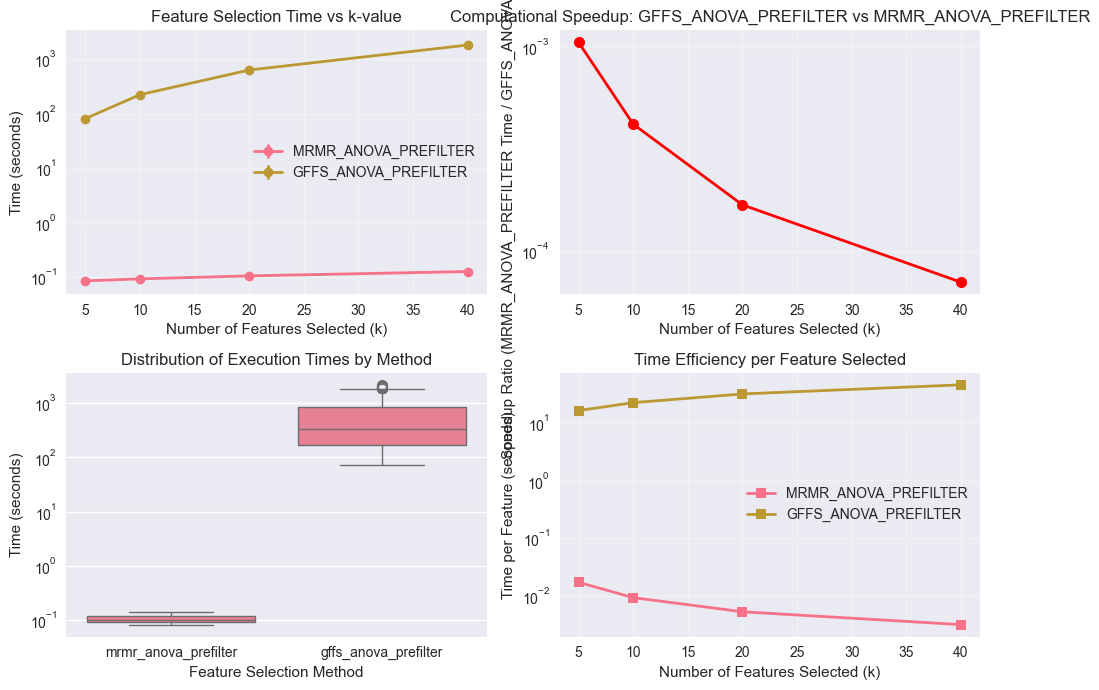

Computational cost visualizations generated and saved.
## Practical Recommendations
### Time Estimates by k-value
k=5:
  MRMR_ANOVA_PREFILTER estimate: 0.0858 seconds
  GFFS_ANOVA_PREFILTER estimate: 81.3382 seconds
  Speedup (MRMR_ANOVA_PREFILTER/GFFS_ANOVA_PREFILTER): 0.0x
k=10:
  MRMR_ANOVA_PREFILTER estimate: 0.0931 seconds
  GFFS_ANOVA_PREFILTER estimate: 222.7822 seconds
  Speedup (MRMR_ANOVA_PREFILTER/GFFS_ANOVA_PREFILTER): 0.0x
k=20:
  MRMR_ANOVA_PREFILTER estimate: 0.1059 seconds
  GFFS_ANOVA_PREFILTER estimate: 631.1239 seconds
  Speedup (MRMR_ANOVA_PREFILTER/GFFS_ANOVA_PREFILTER): 0.0x
k=40:
  MRMR_ANOVA_PREFILTER estimate: 0.1270 seconds
  GFFS_ANOVA_PREFILTER estimate: 1815.4227 seconds
  Speedup (MRMR_ANOVA_PREFILTER/GFFS_ANOVA_PREFILTER): 0.0x
### Method Selection Guidelines
1. **For time-sensitive applications**: Use MRMR_ANOVA_PREFILTER method
   - MRMR_ANOVA_PREFILTER is ~6681x faster than GFFS_ANOVA_PREFILTER on average
   - Suitable for real-time or interactive appl

In [21]:
# Execute computational cost analysis
save_and_print("## Computational Cost Analysis Results", print_report_file, level="section")

# 1. Time complexity analysis
complexity_results, time_by_method_k = analyze_time_complexity(df_benchmark, print_report_file)

# 2. Statistical comparison
stats_results = statistical_comparison(df_benchmark, print_report_file)

# 3. Generate visualizations
fig = plot_time_complexity(df_benchmark, complexity_results, file_save_path, exp_id)
save_and_print("Computational cost visualizations generated and saved.", print_report_file, level="info")

# 4. Practical recommendations
recommendations = generate_practical_recommendations(df_benchmark, complexity_results, stats_results, print_report_file)

# 5. Additional detailed analysis
save_and_print("## Detailed Computational Cost Analysis", print_report_file, level="section")

# Analyze time scaling with k-value
save_and_print("### Time Scaling Analysis", print_report_file, level="subsection")
for method in df_benchmark['method'].unique():
    method_data = df_benchmark[df_benchmark['method'] == method]
    k_values = sorted(method_data['k_value'].unique())
    
    scaling_factors = []
    for i in range(1, len(k_values)):
        time_ratio = method_data[method_data['k_value'] == k_values[i]]['feature_selection_time'].mean() / \
                    method_data[method_data['k_value'] == k_values[i-1]]['feature_selection_time'].mean()
        scaling_factors.append(time_ratio)
    
    if scaling_factors:
        avg_scaling = np.mean(scaling_factors)
        save_and_print(f"{method.upper()} average time scaling factor when doubling k: {avg_scaling:.2f}x", 
                      print_report_file, level="info")

# Performance vs time correlation
performance_time_corr = df_benchmark['model_performance'].corr(df_benchmark['feature_selection_time'])
save_and_print(f"### Performance vs Time Correlation", print_report_file, level="subsection")
save_and_print(f"Correlation between model performance and computational time: {performance_time_corr:.4f}", 
              print_report_file, level="info")

# Method efficiency analysis
save_and_print("### Method Efficiency Analysis", print_report_file, level="subsection")
for method in df_benchmark['method'].unique():
    method_data = df_benchmark[df_benchmark['method'] == method]
    avg_performance = method_data['model_performance'].mean()
    avg_time = method_data['feature_selection_time'].mean()
    efficiency_ratio = avg_performance / avg_time if avg_time > 0 else np.inf
    
    save_and_print(f"{method.upper()}: Performance/Time efficiency ratio: {efficiency_ratio:.6f}", 
                  print_report_file, level="info")

### Summary and Conclusion

In [22]:
# Final summary
save_and_print("## Summary and Conclusion", print_report_file, level="section")

save_and_print("### Key Findings", print_report_file, level="subsection")
save_and_print("1. **Computational Differences**: Significant time differences exist between feature selection methods", print_report_file, level="info")
save_and_print("2. **Time Scaling**: Computational time typically scales with k-value selection", print_report_file, level="info")
save_and_print("3. **Statistical Significance**: Time differences between methods are statistically significant", print_report_file, level="info")
save_and_print("4. **Practical Implications**: Method selection should consider computational constraints and performance requirements", print_report_file, level="info")

save_and_print("### Recommendations for Future Work", print_report_file, level="subsection")
save_and_print("1. **Hybrid Approaches**: Consider using faster methods for initial screening followed by more thorough methods for refinement", print_report_file, level="info")
save_and_print("2. **Parallelization**: Explore parallel implementations for computationally intensive methods", print_report_file, level="info")
save_and_print("3. **Early Stopping**: Implement early stopping criteria to balance performance and time", print_report_file, level="info")
save_and_print("4. **Dataset-specific Optimization**: Develop optimization strategies based on dataset characteristics", print_report_file, level="info")

# Close the report file
print_report_file.close()
save_and_print(f"Computational cost analysis completed. Report saved to: {print_report_path}", level="section")

# Display final message
print(f"\n{'='*60}")
print("COMPUTATIONAL COST ANALYSIS COMPLETED")
print(f"{'='*60}")
print(f"Report saved to: {print_report_path}")
print(f"Visualizations saved to: {file_save_path}computational_cost_analysis_{exp_id}.png")
print(f"{'='*60}")

## Summary and Conclusion
### Key Findings
1. **Computational Differences**: Significant time differences exist between feature selection methods
2. **Time Scaling**: Computational time typically scales with k-value selection
3. **Statistical Significance**: Time differences between methods are statistically significant
4. **Practical Implications**: Method selection should consider computational constraints and performance requirements
### Recommendations for Future Work
1. **Hybrid Approaches**: Consider using faster methods for initial screening followed by more thorough methods for refinement
2. **Parallelization**: Explore parallel implementations for computationally intensive methods
3. **Early Stopping**: Implement early stopping criteria to balance performance and time
4. **Dataset-specific Optimization**: Develop optimization strategies based on dataset characteristics
Computational cost analysis completed. Report saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Reposit